<a href="https://colab.research.google.com/github/Bred321/Khang_Engineering_Portfolio/blob/main/Pytorch_07_Fake_Data_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the libraries


In [ ]:
from google.colab import drive
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn.functional as nnf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn

# Define some parameters
SPLIT_RATIO = 0.2
RANDOM_SEED = 42
BATCH_SIZE  = 32

torch.__version__
torch.optim

<module 'torch.optim' from '/usr/local/lib/python3.10/dist-packages/torch/optim/__init__.py'>

In [ ]:
batch = 3
x_test = torch.Tensor([[1, 2, 3], [3, 7, 8], [11, 12, 13]])
y_test = torch.Tensor([56, 78, 90])
for batch, (x_test, y_test) in enumerate(zip(x_test, y_test)):
  print("The number of batch is: ", batch)
  print("The x_test is: ", x_test)
  print("The y_test is: ", y_test)

The number of batch is:  0
The x_test is:  tensor([1., 2., 3.])
The y_test is:  tensor(56.)
The number of batch is:  1
The x_test is:  tensor([3., 7., 8.])
The y_test is:  tensor(78.)
The number of batch is:  2
The x_test is:  tensor([11., 12., 13.])
The y_test is:  tensor(90.)


In [ ]:
class CustomDatasetV0():
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __getitem__(self, index):
    x = torch.Tensor(self.x[index])
    y = torch.Tensor(self.y[index])
    return (x, y)

  def __len__(self):
    count = self.x.shape[0]
    return count

x_test = np.random.rand(800, 8)
y_test = np.random.rand(800, 1)
test_dataset = CustomDatasetV0(x_test, y_test)
test_data_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
!python -m pip install --upgrade pip

In [ ]:
!cp /content/sample_data/fake_loadcell_data.xlsx /content/drive/MyDrive

# Define the training function

In [ ]:
def training_step(
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    X: torch.Tensor,
    y: torch.Tensor
):
  X = X.to(device)
  y = y.to(device)
  # Training mode
  model.train()

  # Forward pass
  y_pred = model(X)

  # Calculate the loss
  loss = loss_fn(y_pred, y)

  # Zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  return loss



# Define a testing function

In [ ]:
def testing_step(
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    X: torch.Tensor,
    y: torch.Tensor
):
  model.eval()
  with torch.inference_mode():
    test_pred = model(X)
    test_loss = loss_fn(test_pred, y)
    return test_loss

# Create a custom Data class

In [ ]:
class CustomDataset():
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __getitem__(self, index):
    x = torch.Tensor(self.x[index])
    y = torch.Tensor(self.y[index])
    return (x, y)

  def __len__(self):
    count = self.x.shape[0]
    return count

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Preprocessing the data

WARNING:
- Almost all the data in the Excel is generated by the rand() function in Excel, so the model performance cannot be evaluated accurately compared to the real-world context --> Overfitting is likely to happen due to the extreme data randomness
- Several models built here just serves the concept purpose to see how they will perform in a scenario of eight random-generated inputs and one output  
- Real-world data-filled model may have to require restructuring and adjusting the model hyperparameters, as well as the choice of loss function.
- Despite all of that, this document still reflects the accurate process of preparing the data that can be applied to the real-world situations.

In [ ]:
df = pd.read_excel('/content/sample_data/fake_loadcell_data.xlsx')
df.describe()

,Cell 1 weight,Cell 2 weight,Cell 3 weight,Cell 4 weight,Cell 5 weight,Cell 6 weight,Cell 7 weight,Cell 8 weight,Velocity
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,10.139217,10.263606,10.474098,10.662438,10.525505,10.484145,10.740964,10.663646,124.753707
std,5.489024,5.339521,5.518379,5.546373,5.521977,5.419946,5.481079,5.484586,14.502811
min,1.003743,1.042549,1.031927,1.019026,1.000440,1.007646,1.000172,1.038075,100.126591
25%,5.188829,5.788627,5.580762,5.784623,5.649421,5.961098,5.987734,6.102432,112.070265
50%,10.044141,10.000878,10.400334,10.738197,10.418947,10.421429,10.756564,10.441817,124.627823
75%,14.815614,14.814349,15.299928,15.436674,15.484849,15.003229,15.413992,15.393914,137.224417
max,19.947990,19.994808,19.987841,19.994019,19.987781,19.988458,19.990818,19.986427,149.954036


In [ ]:
# Convert the data to PyTorch
cell_1_data = torch.from_numpy(df['Cell 1 weight'].to_numpy()).type(torch.float)
cell_2_data = torch.from_numpy(df['Cell 2 weight'].to_numpy()).type(torch.float)
cell_3_data = torch.from_numpy(df['Cell 3 weight'].to_numpy()).type(torch.float)
cell_4_data = torch.from_numpy(df['Cell 4 weight'].to_numpy()).type(torch.float)
cell_5_data = torch.from_numpy(df['Cell 5 weight'].to_numpy()).type(torch.float)
cell_6_data = torch.from_numpy(df['Cell 6 weight'].to_numpy()).type(torch.float)
cell_7_data = torch.from_numpy(df['Cell 7 weight'].to_numpy()).type(torch.float)
cell_8_data = torch.from_numpy(df['Cell 8 weight'].to_numpy()).type(torch.float)
velocity_data = torch.from_numpy(df['Velocity'].to_numpy()).type(torch.float)

# Plot the correlation between the cell weight and velocity value

Text(0, 0.5, 'Velocity values')

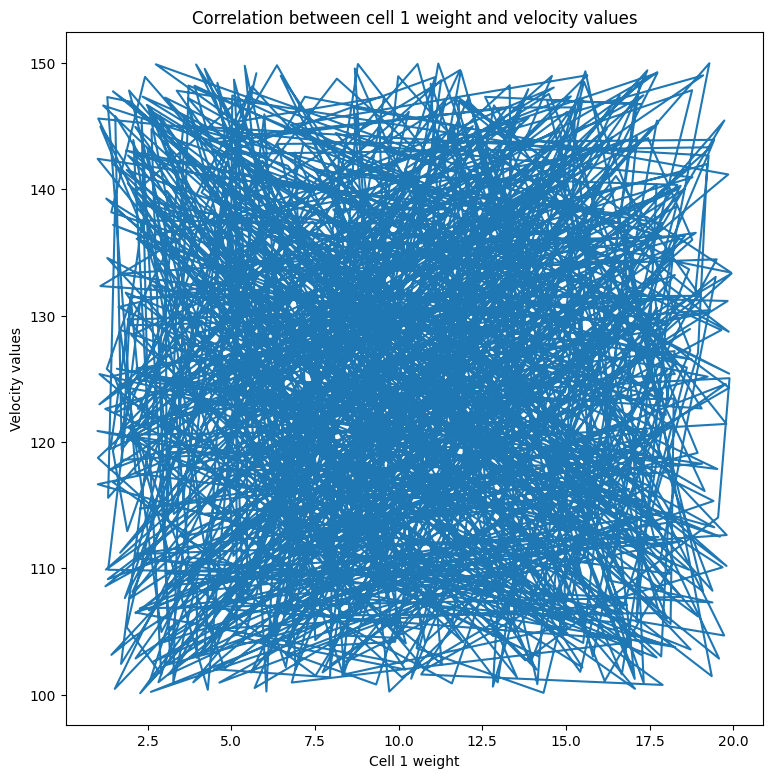

In [ ]:
plt.figure(figsize=(9, 9))
plt.plot(cell_1_data, velocity_data)
plt.title('Correlation between cell 1 weight and velocity values')
plt.xlabel('Cell 1 weight')
plt.ylabel('Velocity values')

# Scatter plot of the cell weight value

Text(0, 0.5, 'Velocity values')

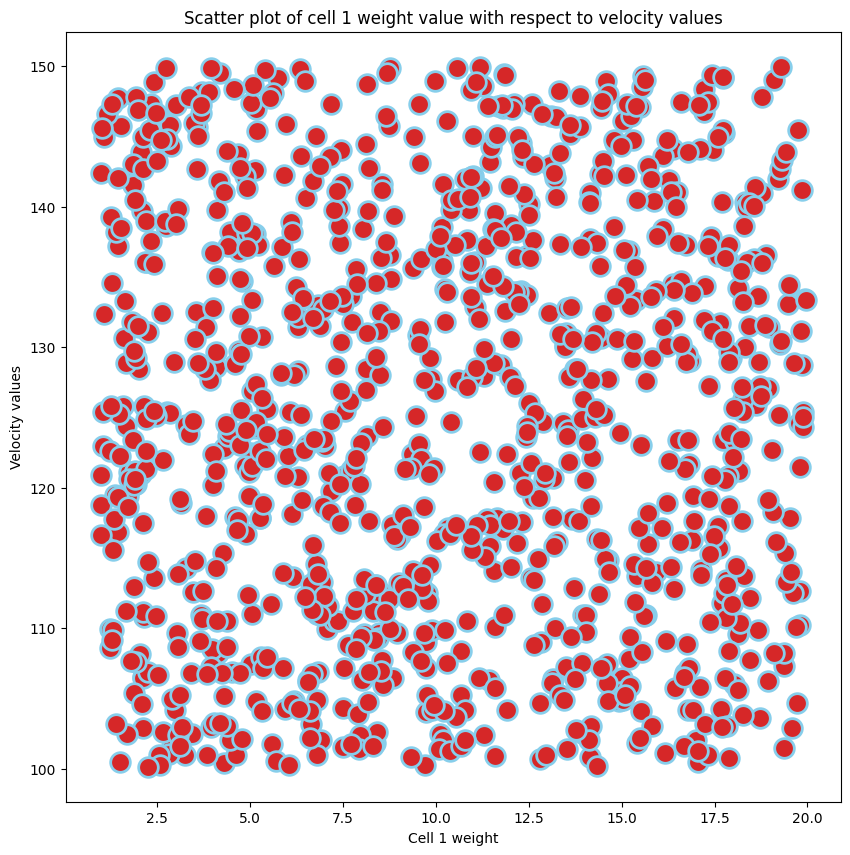

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(cell_1_data, velocity_data, s=200, color='#d62728', edgecolor="skyblue", linewidth=2)
plt.title('Scatter plot of cell 1 weight value with respect to velocity values')
plt.xlabel('Cell 1 weight')
plt.ylabel('Velocity values')

# Plot the heatmap between the data points

[Text(0.5, 1.0, 'Heat map between weight cells and velocity values')]

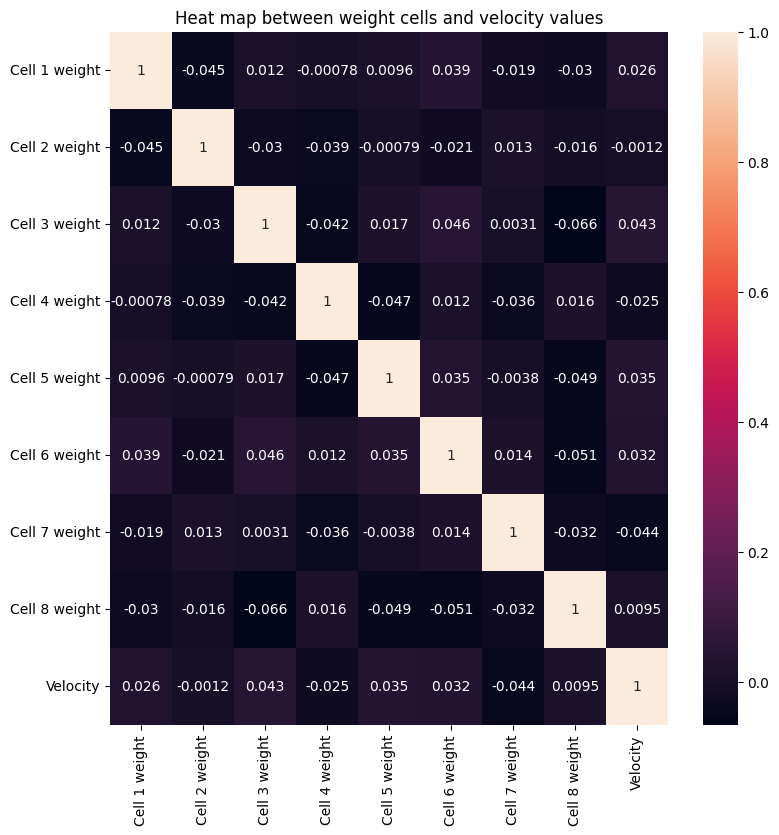

In [ ]:
plt.figure(figsize=(9, 9))
correlation = df.corr()
seaborn.heatmap(correlation, annot=True).set(title='Heat map between weight cells and velocity values')

# Plot the histogram of the data

Text(0.5, 1.0, 'Velocity values')

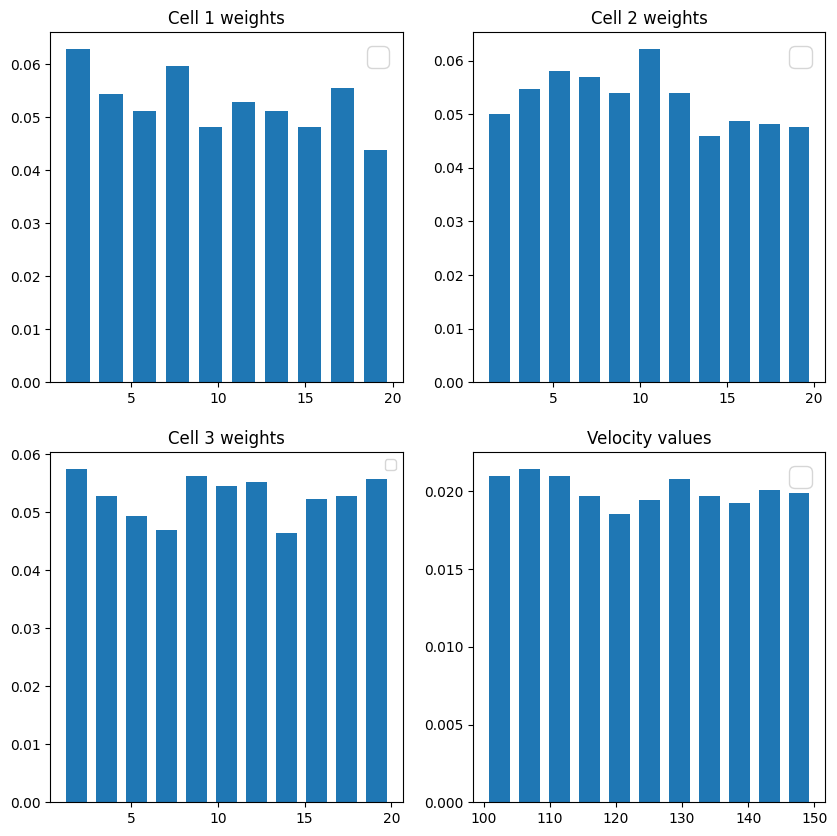

In [ ]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax0.hist(cell_1_data, bins=10, density=True, histtype='bar', rwidth=0.7)
ax0.set_label('Cell 1 weights')
ax0.legend(prop={'size': 20})
ax0.set_title('Cell 1 weights')

ax1.hist(cell_2_data, bins='auto', density=True, histtype='bar', rwidth=0.7)
ax1.legend(prop={'size': 20})
ax1.set_title('Cell 2 weights')

ax2.hist(cell_3_data, bins='auto', density=True, histtype='bar', rwidth=0.7)
ax2.legend(prop={'size': 10})
ax2.set_title('Cell 3 weights')

ax3.hist(velocity_data, bins='auto', density=True, histtype='bar', rwidth=0.7)
ax3.legend(prop={'size': 20})
ax3.set_title('Velocity values')

In [ ]:
loadcell_data = torch.stack([cell_1_data, cell_2_data, cell_3_data, cell_4_data,
                             cell_5_data, cell_6_data, cell_7_data, cell_8_data])
loadcell_data = torch.transpose(loadcell_data, 0, 1)
loadcell_data.shape

torch.Size([999, 8])

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(loadcell_data,
                                                     velocity_data,
                                                     test_size=SPLIT_RATIO,
                                                     random_state=RANDOM_SEED)
# y_train = torch.round(y_train)
# y_test = torch.round(y_test)
len(X_train), len(X_test), X_train.shape, X_train[0:3], y_train[0:3]

(799,
 200,
 torch.Size([799, 8]),
 tensor([[12.4614, 15.1310,  1.7408, 18.3615,  8.0782,  2.6910,  2.4163,  9.6197],
         [12.2189,  2.9478, 14.1324,  5.3956, 16.2516, 19.5807, 19.5857, 13.2472],
         [11.0580,  7.9046, 17.1363,  7.0280, 16.0569,  9.2511,  9.7470, 12.1146]]),
 tensor([123.9536, 133.9437, 136.0398]))

# Prepare the DataLoader

In [ ]:
# train_data = CustomDataset(X_train, y_train)
# train_data_loader = DataLoader(
#     train_data,
#     batch_size=BATCH_SIZE,
#     shuffle=True
# )

# test_data = CustomDataset(X_test, y_test)
# test_data_loader = DataLoader(
#     test_data,
#     batch_size=BATCH_SIZE,
#     shuffle=False
# )

# for batch, (X, y) in train_data:
#   print(batch)
#   print(X, y)


# Create an ANN Model

In [ ]:
# Define a model module
class LoadcellANNModel(nn.Module):
  def __init__(self, input_features, hidden_units, output_features):
    super().__init__()
    self.stacked_layers = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.LeakyReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.LeakyReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.LeakyReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.stacked_layers(x)

In [ ]:
# Create a class instance
load_ann_model_0 = LoadcellANNModel(input_features=8, hidden_units=128, output_features=1).to(device)
load_ann_model_0

LoadcellANNModel(
  (stacked_layers): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
# Define a loss function
loss_fn = nn.L1Loss()

# Define an optimizer function
optimizer = torch.optim.Adam(params=load_ann_model_0.parameters(), lr=0.1)

# Train the ANN Model

In [ ]:
# Random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Define the number of epochs
epochs = 1000
print(X_train.shape)

# Move the data to the selected device
X_train, y_train = X_train.to(device).squeeze(), y_train.to(device).squeeze()
X_test, y_test = X_test.to(device).squeeze(), y_test.to(device).squeeze()

# Create a training loop
for epoch in tqdm(range(epochs)):
  train_loss = training_step( model=load_ann_model_0,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              X=X_train,
                              y=y_train)

  test_loss = testing_step( model=load_ann_model_0,
                            loss_fn=loss_fn,
                            X=X_test,
                            y=y_test
                            )
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {train_loss} | Test loss: {test_loss}")

torch.Size([799, 8])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 | Loss: 124.97869110107422 | Test loss: 891.8508911132812


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([799])) that is different to the input size (torch.Size([799, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 100 | Loss: 20.191814422607422 | Test loss: 20.501070022583008
Epoch: 200 | Loss: 19.11522674560547 | Test loss: 20.064550399780273
Epoch: 300 | Loss: 26.919353485107422 | Test loss: 30.156824111938477
Epoch: 400 | Loss: 15.352272033691406 | Test loss: 15.344618797302246
Epoch: 500 | Loss: 12.94168472290039 | Test loss: 14.236117362976074
Epoch: 600 | Loss: 12.647012710571289 | Test loss: 12.613585472106934
Epoch: 700 | Loss: 13.891923904418945 | Test loss: 14.030780792236328
Epoch: 800 | Loss: 12.575681686401367 | Test loss: 12.571566581726074
Epoch: 900 | Loss: 12.569865226745605 | Test loss: 12.5665864944458


Model Performance document:
- One hidden layer (with RELU() --> MAE:, LeakyRELU() --> MAE:, ELU() --> MAE: )
- Two hidden layers (with RELU() --> MAE:, LeakyRELU() --> MAE:, ELU() --> MAE: )
- Three hidden layers (with RELU() --> MAE:, LeakyRELU() --> MAE:, ELU() --> MAE: )

# Implement a LSTM model

In [ ]:
loadcell_data = torch.stack([cell_1_data, cell_2_data, cell_3_data, cell_4_data,
                             cell_5_data, cell_6_data, cell_7_data, cell_8_data])
loadcell_data = torch.transpose(loadcell_data, 0, 1)
loadcell_data.shape

torch.Size([999, 8])

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(loadcell_data,
                                                     velocity_data,
                                                     test_size=SPLIT_RATIO,
                                                     random_state=RANDOM_SEED)
# y_train = torch.round(y_train)
# y_test = torch.round(y_test)
len(X_train), len(X_test), X_train.shape

(799, 200, torch.Size([799, 8]))

In [ ]:
class LoadcellLSTMModel(nn.Module):
  def __init__(self, input_features, hidden_units, num_layers, output_features):
    super().__init__()
    self.hidden_units = hidden_units
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size=input_features,
                        hidden_size=hidden_units,
                        num_layers=num_layers,
                        batch_first=False)
    self.linear = nn.Linear(in_features=hidden_units,
                            out_features=output_features)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    x = x.unsqueeze(0)
    x = nnf.relu(x)
    y_out, _ = self.lstm(x)
    y_out = nnf.relu(y_out)
    return self.linear(y_out)

In [ ]:
load_rnn_model_0 = LoadcellLSTMModel(input_features=8, hidden_units=64, num_layers=5, output_features=1).to(device)
load_rnn_model_0

LoadcellLSTMModel(
  (lstm): LSTM(8, 64, num_layers=5)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
# Define a loss function
loss_fn = nn.L1Loss()

# Define an optimizer function
optimizer = torch.optim.Adam(params=load_ann_model_0.parameters(), lr=0.01)

In [ ]:
# Random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Define the number of epochs
epochs = 1000
print(X_train.shape)

# Move the data to the selected device
X_train, y_train = X_train.to(device).squeeze(), y_train.to(device).squeeze()
X_test, y_test = X_test.to(device).squeeze(), y_test.to(device).squeeze()

# Create a training loop
for epoch in tqdm(range(epochs)):
  train_loss = training_step(model=load_rnn_model_0,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              X=X_train,
                              y=y_train)

  test_loss = testing_step(model=load_rnn_model_0,
                            loss_fn=loss_fn,
                            X=X_test,
                            y=y_test)
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {train_loss} | Test loss: {test_loss}")

torch.Size([799, 8])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 | Loss: 124.84129333496094 | Test loss: 124.08513641357422


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([799])) that is different to the input size (torch.Size([1, 799, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([1, 200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 100 | Loss: 124.84129333496094 | Test loss: 124.08513641357422
Epoch: 200 | Loss: 124.84129333496094 | Test loss: 124.08513641357422
Epoch: 300 | Loss: 124.84129333496094 | Test loss: 124.08513641357422
Epoch: 400 | Loss: 124.84129333496094 | Test loss: 124.08513641357422
Epoch: 500 | Loss: 124.84129333496094 | Test loss: 124.08513641357422
Epoch: 600 | Loss: 124.84129333496094 | Test loss: 124.08513641357422
Epoch: 700 | Loss: 124.84129333496094 | Test loss: 124.08513641357422
Epoch: 800 | Loss: 124.84129333496094 | Test loss: 124.08513641357422
Epoch: 900 | Loss: 124.84129333496094 | Test loss: 124.08513641357422


In [ ]:
input = torch.randn(5, 3, 10)
input

tensor([[[ 1.9269e+00,  1.4873e+00,  9.0072e-01, -2.1055e+00,  6.7842e-01,
          -1.2345e+00, -4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00],
         [-3.9248e-01, -1.4036e+00, -7.2788e-01, -5.5943e-01, -7.6884e-01,
           7.6245e-01,  1.6423e+00, -1.5960e-01, -4.9740e-01,  4.3959e-01],
         [-7.5813e-01,  1.0783e+00,  8.0080e-01,  1.6806e+00,  1.2791e+00,
           1.2964e+00,  6.1047e-01,  1.3347e+00, -2.3162e-01,  4.1759e-02]],

        [[-2.5158e-01,  8.5986e-01, -1.3847e+00, -8.7124e-01, -2.2337e-01,
           1.7174e+00,  3.1888e-01, -4.2452e-01,  3.0572e-01, -7.7459e-01],
         [-1.5576e+00,  9.9564e-01, -8.7979e-01, -6.0114e-01, -1.2742e+00,
           2.1228e+00, -1.2347e+00, -4.8791e-01, -9.1382e-01, -6.5814e-01],
         [ 7.8024e-02,  5.2581e-01, -4.8799e-01,  1.1914e+00, -8.1401e-01,
          -7.3599e-01, -1.4032e+00,  3.6004e-02, -6.3477e-02,  6.7561e-01]],

        [[-9.7807e-02,  1.8446e+00, -1.1845e+00,  1.3835e+00,  1.4451e+00,
           8.56